In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["lines.linewidth"] = 2

# load pre-scraped, cleaned data
vix_df = pd.read_csv("../data/raw/vix_ytd_ohlc.csv", parse_dates=["Date"])
spx_df = pd.read_csv("../data/raw/sp500_ytd_ohlcv.csv", parse_dates=["Date"])

# compute daily % changes
vix_df["dVIX"] = vix_df["Close"].pct_change()
spx_df["dSPX"] = spx_df["Adj Close"].pct_change()

merged = pd.merge(
    vix_df[["Date","dVIX"]],
    spx_df[["Date","dSPX"]],
    on="Date",
    how="inner"
).dropna()
merged.head()

,Date,dVIX,dSPX
1,2025-01-03,-0.100390,0.012596
2,2025-01-06,-0.005580,0.005538
3,2025-01-07,0.110973,-0.011104
4,2025-01-08,-0.006734,0.001560
5,2025-01-10,0.103955,-0.015412


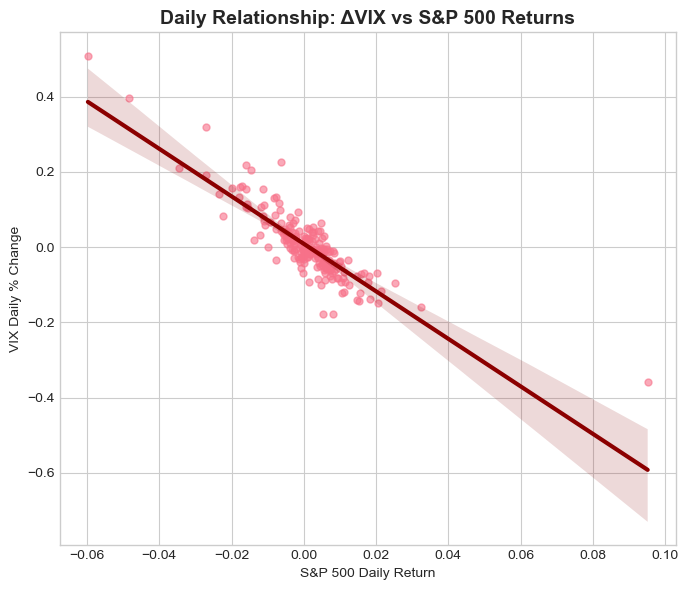

In [2]:
sns.set_palette("husl")

plt.figure(figsize=(7,6))
sns.regplot(
    data=merged,
    x="dSPX", y="dVIX",
    scatter_kws={"alpha":0.6, "s":25},
    line_kws={"color":"darkred"}
)
plt.title("Daily Relationship: ΔVIX vs S&P 500 Returns", fontsize=14, weight="bold")
plt.xlabel("S&P 500 Daily Return")
plt.ylabel("VIX Daily % Change")

plt.tight_layout()
os.makedirs("../reports/figures", exist_ok=True)
plt.savefig("../reports/figures/vix_spx_regression.png", dpi=300, bbox_inches="tight")
plt.show()


In [3]:
X = sm.add_constant(merged["dSPX"])   # add intercept
y = merged["dVIX"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   dVIX   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     639.5
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           1.17e-65
Time:                        11:46:02   Log-Likelihood:                 356.85
No. Observations:                 212   AIC:                            -709.7
Df Residuals:                     210   BIC:                            -703.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.003      2.834      0.0

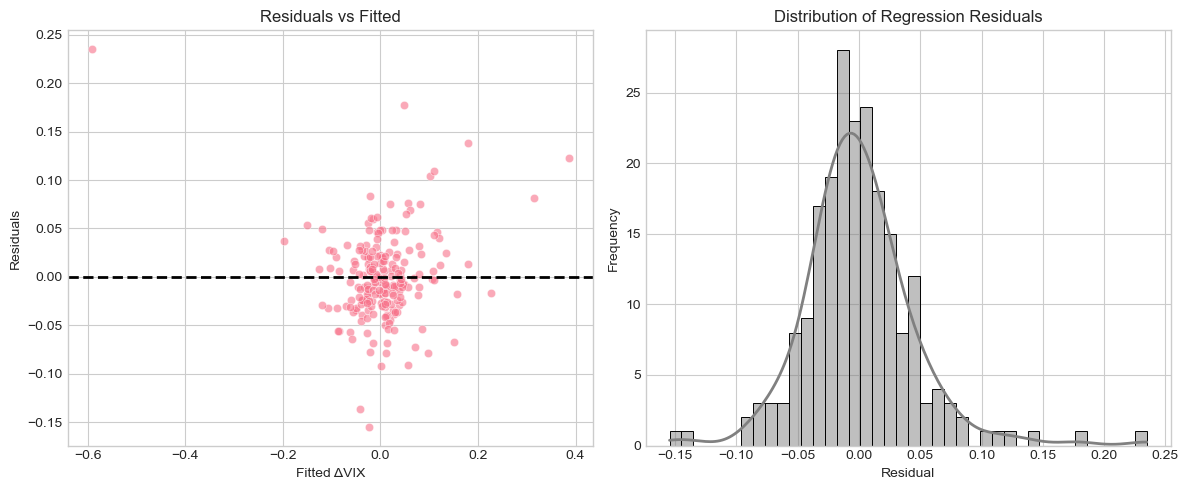

In [4]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

# residual vs fitted
sns.scatterplot(x=model.fittedvalues, y=model.resid, ax=ax[0], alpha=0.6)
ax[0].axhline(0, color="black", linestyle="--")
ax[0].set_title("Residuals vs Fitted")
ax[0].set_xlabel("Fitted ΔVIX"); ax[0].set_ylabel("Residuals")

# histogram of residuals
sns.histplot(model.resid, bins=40, kde=True, ax=ax[1], color="gray")
ax[1].set_title("Distribution of Regression Residuals")
ax[1].set_xlabel("Residual"); ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("../reports/figures/vix_spx_regression_diagnostics.png", dpi=300, bbox_inches="tight")
plt.show()